En esta actividad vamos a analizar el gráfico del precio de diferentes criptomonedas con el objetivo de detectar tendencias. 
Antes de nada, vamos a ver los datos históricos expuestos en los datasets obtenidos de kaggle. Como modelo de referencia usaremos los datos del Bitcoin.

Lo primero que haremos será importar las bibliotecas que vamos a utilizar.

In [1]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Ahora vamos a echar un vistazo a los datos que tenemos de Bitcoin

In [2]:
df = pd.read_csv("historicos/coin_Bitcoin.csv")
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


Aquí inmediatamente saltan a la vista dos problemas. El primero es que sólo hay datos hasta el 6 de julio de 2021, cuando el mercado ha cambiado enormemente en este último medio año.
El segundo es que hay varias métricas que no vamos a utilizar.

Antes de modificar nada, vamos a ver de dónde podemos sacar los datos más recientes, lo cual es mucho más difícil de lo que parece. Tras investigar, hemos visto que la única forma de obtener los datos más recientes es haciendo peticiones a páginas que ofrecen este tipo de servicios. Estas páginas son conscientes del valor de estos datos, por ello sólo dan acceso completo a sus datos a aquellos usuarios que paguen una subscripción.
De todas formas la versión gratuita nos da información sobre los últimos 200 días, y dado que desde el día actual hasta el último registro del dataset hay menos de 200 días, podemos usar el servicio gratuito sin problemas.

Para ver cómo lo podríamos juntar, vamos a ver en qué formato se encuentran estos datos haciendo una petición.

In [4]:
apiUrl = "https://api.pro.coinbase.com" # Enlace de la API
sym = "BTC-USD" # Símbolo del par de divisas cuya relación queremos obtener
end_date = datetime.now().date().isoformat()
start_date = "2021-07-07"
barsize = "86400" # Tiempo entre registros (en segundos)
parameters = {
    "start": start_date,
    "end": end_date,
    "granularity": barsize,
}
headers = {"content-type": "application/json"}
data = requests.get(f"{apiUrl}/products/{sym}/candles", params=parameters, headers=headers)
datos = data.json()
datos

[[1641168000, 45737, 47583.33, 47299.06, 45792.19, 8626.12740493],
 [1641081600, 46633.36, 47990, 47733.43, 47299.07, 6833.49845548],
 [1640995200, 46205, 47967.12, 46211.24, 47733.43, 9463.6617111],
 [1640908800, 45650, 48574.7, 47122.09, 46211.24, 19010.24134509],
 [1640822400, 45938.44, 47926.15, 46471.24, 47122.08, 27413.65364976],
 [1640736000, 46094.02, 48149.58, 47542.2, 46471.24, 20326.32142372],
 [1640649600, 47300.23, 50720.35, 50720.35, 47543.09, 23116.75583707],
 [1640563200, 50480, 52100, 50804.33, 50717.77, 11596.91468191],
 [1640476800, 49460, 51295.33, 50428.31, 50801.79, 6863.39473781],
 [1640390400, 50191.84, 51171.68, 50852.31, 50428.31, 5550.57153185],
 [1640304000, 50445.55, 51878.6, 50842.06, 50851.38, 11690.45418179],
 [1640217600, 48032.16, 51397.82, 48608.61, 50842.2, 16627.04627954],
 [1640131200, 48450, 49595, 48914.7, 48608.62, 10753.4990677],
 [1640044800, 46645.05, 49339.31, 46926.07, 48914.7, 15461.4105731],
 [1639958400, 45568, 47548.93, 46687.2, 46926.0

Vemos que obtenemos los datos en forma de array de arrays. Por cómo están entrelazados, vemos que aparte de la timestamp tenemos el precio mínimo, máximo, de apertura y de clausura diarios respectivamente. Además, al analizar los timestamps vemos que los datos están al revés de como querríamos verlos (va de día actual a 7 de julio).

Vamos a modificar los datasets originales para que tenga los datos que nos interesan, luego uniremos el resultado junto con estos resultados que obtenemos de la petición.

In [5]:
def modify_lines(line): # Modificamos cada línea del cav para dejar los datos que 
    data = line.split(',') # vayan a jugar un papel importante en nuestro análisis
    return "{},{},{:.2f},{:.2f},{:.2f},{:.2f}\n".format(data[2], data[3][:10], float(data[4]), float(data[5]), float(data[6]), float(data[7]))

def get_lines(file): # Obtenemos cada línea del csv como array, luego las modificamos
    with open(file, "r") as coin:
        lines = coin.readlines() 
        return ["Symbol,Date,High,Low,Open,Close\n"] + [modify_lines(line) for line in lines[1::]]


with open("historicos/bitcoin_limpio.csv", "w") as coin: # Creamos un nuevo archivo con nuestras modificaciones
    coin.writelines(get_lines("historicos/coin_Bitcoin.csv"))

Veamos qué aspecto tiene nuestro dataset modificado

In [6]:
cleaned_df = pd.read_csv("historicos/bitcoin_limpio.csv")
cleaned_df

,Symbol,Date,High,Low,Open,Close
0,BTC,2013-04-29,147.49,134.00,134.44,144.54
1,BTC,2013-04-30,146.93,134.05,144.00,139.00
2,BTC,2013-05-01,139.89,107.72,139.00,116.99
3,BTC,2013-05-02,125.60,92.28,116.38,105.21
4,BTC,2013-05-03,108.13,79.10,106.25,97.75
...,...,...,...,...,...,...
2986,BTC,2021-07-02,33939.59,32770.68,33549.60,33897.05
2987,BTC,2021-07-03,34909.26,33402.70,33854.42,34668.55
2988,BTC,2021-07-04,35937.57,34396.48,34665.56,35287.78
2989,BTC,2021-07-05,35284.34,33213.66,35284.34,33746.00


Perfecto, mucho más limpio y entendible. Ahora vamos a modificar los resultados la API para poder añadirlos. Vamos a meterlos también en una función para que realizar estas operaciones más cómodamente en el resto de  datasets.

In [7]:
apiUrl = "https://api.pro.coinbase.com"
sym = "BTC-USD"
start_date = "2021-07-07"

def get_prices(sym, end_date, start_date):
    barsize = "86400" #  Tiempo en segundos entre registros
    parameters = {
        "start": start_date,
        "end": end_date,
        "granularity": barsize,
    }
    headers = {"content-type": "application/json"}
    data = requests.get(f"{apiUrl}/products/{sym}/candles", params=parameters, headers=headers)
    datos = data.json()[::-1] # Damos la vuelta para obtener primero los más antiguos
    return datos

precios = get_prices(sym, end_date=end_date, start_date=start_date)

fechas = pd.date_range(start=start_date, end=end_date).to_list()
fechas = [time.strftime("%Y-%m-%d") for time in fechas] # Obtenemos fechas de cada registro

todo_junto = [f"{sym[:3]},{fechas[i]},{precios[i][2]},{precios[i][1]},{precios[i][3]},{precios[i][4]}\n" for i in range(len(precios))]
# Especificamos los campos para el nuevo csv. Los elementos 1 y 2 han sido invertidos para 
# tener el mismo formato que el csv original.

with open("historicos/bitcoin_limpio.csv", "a") as coin: # Completamos nuestro csv limpiado
    coin.writelines(todo_junto)

Ahora comprobamos que en nuestro dataframe se han escrito los datos correctamente

In [8]:
final_df = pd.read_csv("historicos/bitcoin_limpio.csv")
final_df

,Symbol,Date,High,Low,Open,Close
0,BTC,2013-04-29,147.49,134.00,134.44,144.54
1,BTC,2013-04-30,146.93,134.05,144.00,139.00
2,BTC,2013-05-01,139.89,107.72,139.00,116.99
3,BTC,2013-05-02,125.60,92.28,116.38,105.21
4,BTC,2013-05-03,108.13,79.10,106.25,97.75
...,...,...,...,...,...,...
3167,BTC,2021-12-30,47926.15,45938.44,46471.24,47122.08
3168,BTC,2021-12-31,48574.70,45650.00,47122.09,46211.24
3169,BTC,2022-01-01,47967.12,46205.00,46211.24,47733.43
3170,BTC,2022-01-02,47990.00,46633.36,47733.43,47299.07


Todo pinta fantástico, es el momento de añadirle nuevos campos

In [9]:
final_df['variacion_diaria'] = final_df.apply(lambda row: (row.Close - row.Open) / row.Open * 100, axis=1)
# Añadimos una columna que nos indique cuánto ha cambiado porcentualmente el precio de la divisa cada día
final_df['promedio_movil_200_semanas'] = final_df['Open'].rolling(window = 1400).mean()
# Añadimos el promedio medio móvil de 200 semanas
final_df

,Symbol,Date,High,Low,Open,Close,variacion_diaria,promedio_movil_200_semanas
0,BTC,2013-04-29,147.49,134.00,134.44,144.54,7.512645,NaN
1,BTC,2013-04-30,146.93,134.05,144.00,139.00,-3.472222,NaN
2,BTC,2013-05-01,139.89,107.72,139.00,116.99,-15.834532,NaN
3,BTC,2013-05-02,125.60,92.28,116.38,105.21,-9.597869,NaN
4,BTC,2013-05-03,108.13,79.10,106.25,97.75,-8.000000,NaN
...,...,...,...,...,...,...,...,...
3167,BTC,2021-12-30,47926.15,45938.44,46471.24,47122.08,1.400522,18633.023864
3168,BTC,2021-12-31,48574.70,45650.00,47122.09,46211.24,-1.932958,18658.841500
3169,BTC,2022-01-01,47967.12,46205.00,46211.24,47733.43,3.293982,18683.919600
3170,BTC,2022-01-02,47990.00,46633.36,47733.43,47299.07,-0.909970,18709.802479


Estos dos datos nos dan información valiosísima sobre la evolución del precio de bitcoin a lo largo de los años. Podemos visualizarlo en un gráfico para ver el gran valor de estos campos.

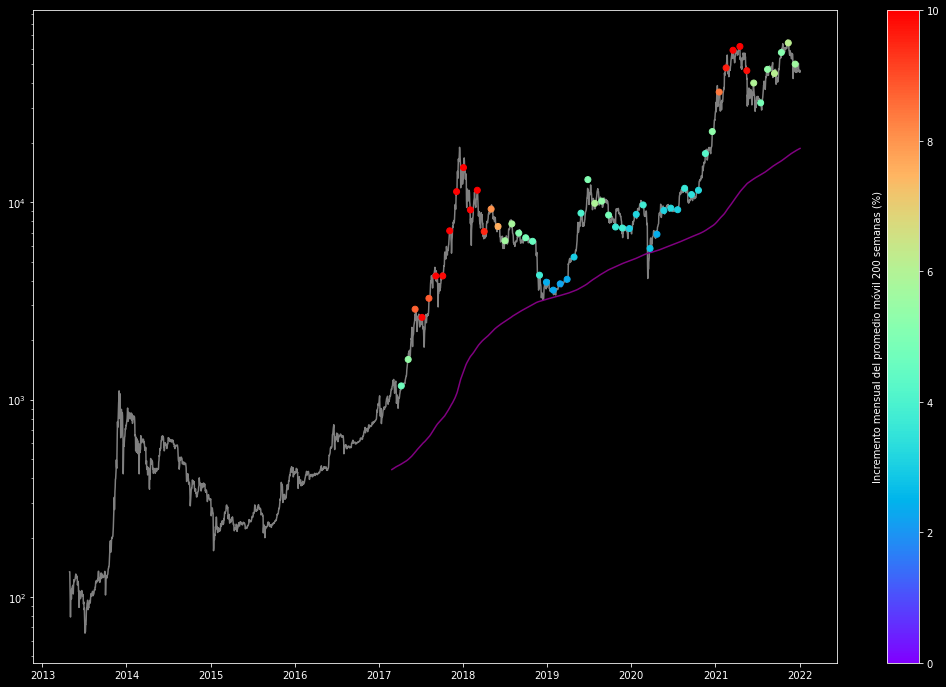

In [12]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.style.use("dark_background")
mensual = final_df[::30]
distancia = mensual['promedio_movil_200_semanas'].pct_change() * 100
dates = pd.to_datetime(final_df['Date'])
plt.semilogy(dates, final_df['Low'], color="gray", zorder=1);
plt.semilogy(dates, final_df['promedio_movil_200_semanas'], color="purple", zorder=2);
plt.scatter(mensual['Date'], mensual['Open'], c=distancia, cmap='rainbow', vmin=0, vmax=10, zorder=3)

cbar = plt.colorbar()
cbar.set_label("Incremento mensual del promedio móvil 200 semanas (%)")
cbar.ax.yaxis.set_label_position("left")

De este gráfico podemos sacar bastantes conclusiones. Históricamente, cuando el Bitcoin ha estado más cerca de su promedio móvil de 200 semanas se han dado las mejores oportunidades de compra, mientras que una variación brusca de la misma ha conllevado una igualmente brusca corrección de mercado a corto-medio plazo.

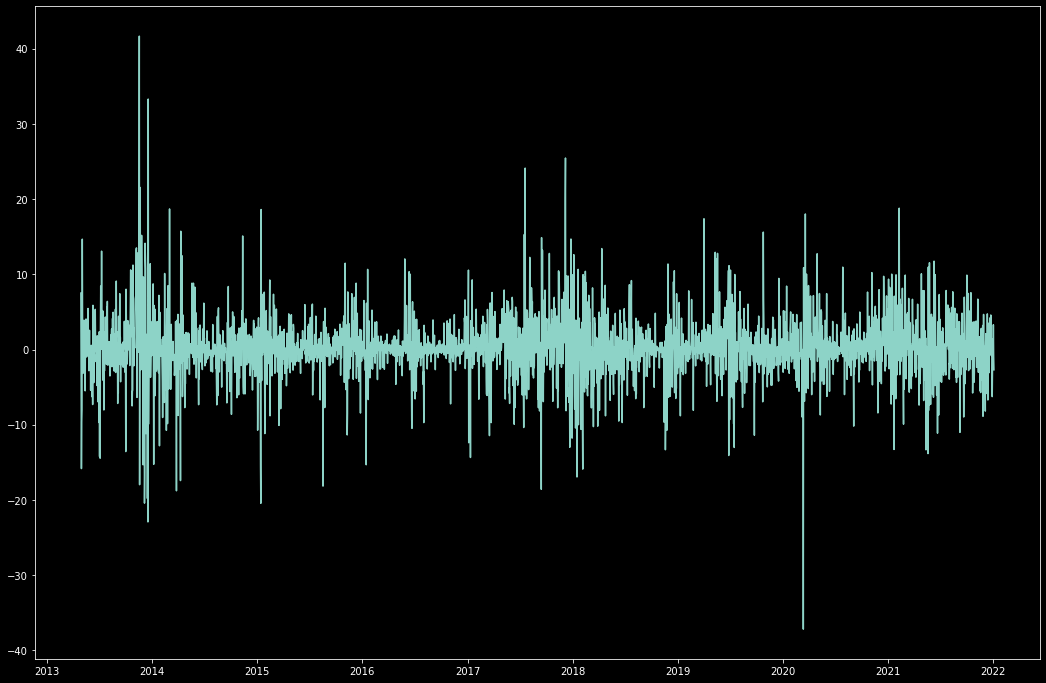

In [15]:
plt.plot(dates, final_df['variacion_diaria']);

Este gráfico nos dice que, a medida que bitcoin y el mercado de las criptomonedas en general han ido variando en el tiempo, las variaciones diarias de su precio se han ido disminuyendo.

CONCLUSIÓN:
Hemos llevado a cabo una extracción de datos históricos de los precios de bitcoin, los hemos complementado con datos proporcionados con la API de coinbase y hemos calculado distintas métricas que nos pueden ayudar a entender el comportamiento del mismo y a encontrar los mejores puntos de compra y venta. Lo hemmos hecho de tal forma que se podría repetir el mismo análisis fácilmente para cuelquiera de las criptomonedas propuestas, e incluso estudiar el efecto de una sobre otra.

En el futuro podríamos calcular distintas métricas (promedio móvil de 20, 50, 100 semanas, etc) y usar algoritmos de machine learning que nos permitan encontrar los puntos idóneos de compra y venta de cualquier criptomoneda, con lo que podríamos programar un bot de trading y sacar un dinero extra.